
Loading Libraries and Image Preprocessing

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, Dense, Dropout, Flatten
from keras.preprocessing import image
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import random
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold, StratifiedKFold
from keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
zip_file = '/content/Train.zip'

with ZipFile(zip_file, 'r') as zip:
  zip.extractall()
  print("Done")

In [ ]:
train_directory = '/content/drive/Shareddrives/ECEN 404 Machine Learning/Color/Final Model/Dataset/Train'
classes = ["Healthy", "Yellow Leaf Curl"]

In [ ]:
# https://www.analyseup.com/python-machine-learning/stratified-kfold.html

train_data = pd.read_csv('/content/drive/Shareddrives/ECEN 404 Machine Learning/Color/Final Model/train_labels.csv')
print(f"Data Ratio: {sum(train_data['labels']/len(train_data['labels']))}")
train_data['labels'] = train_data['labels'].astype(str)
Y = train_data[['labels']]

kf = KFold(n_splits = 5)
                         
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 

train_data

Data Ratio: 0.6687516288766899


,filename,labels
0,Vertical_Flip_Tomato_Yellow_Leaf_Curl_1139.JPG,1
1,Tomato_Yellow_Leaf_Curl_1776.JPG,1
2,Tomato_Healthy_0179.JPG,0
3,Tomato_Yellow_Leaf_Curl_1780.JPG,1
4,Shearing_Tomato_Yellow_Leaf_Curl_2152.JPG,1
...,...,...
19180,Shearing_Tomato_Yellow_Leaf_Curl_0189.JPG,1
19181,Gaussian_Blur_Tomato_Yellow_Leaf_Curl_0611.JPG,1
19182,Vertical_Flip_Tomato_Yellow_Leaf_Curl_2958.JPG,1
19183,Shearing_Tomato_Yellow_Leaf_Curl_1308.JPG,1


In [ ]:
print(f"Total Size of Dataset: {len(train_data)}")

Total Size of Dataset: 19185


In [ ]:
fold_no = 1
for train_index, test_index in skf.split(train_data, Y):
  train = train_data.loc[train_index,:]
  test = train_data.loc[test_index,:]
  print(f"Fold {str(fold_no)} Class Ratio {sum(test['labels'])/len(test['labels'])}")
  fold_no += 1

([<matplotlib.axis.XTick at 0x7f8ef7714a60>,
 [Text(0, 0, 'Yellow Leaf Curl'), Text(0, 0, 'Healthy')])

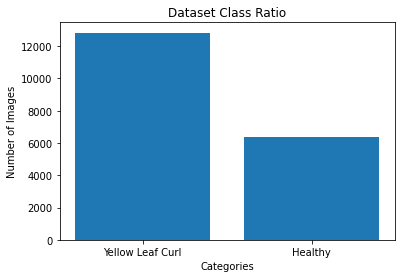

In [ ]:
#Checking if distribution of target labels are equal
# 1 Indicates Yellow Leaf Curl
# 2) Indicated Healthy
x_bars = ["Yellow Leaf Curl", "Healthy"]
plt.bar(Y['labels'].value_counts().index, Y['labels'].value_counts().values)
plt.title('Dataset Class Ratio')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.xticks(Y['labels'].value_counts().index, x_bars)

In [ ]:
name = 'Vertical_Flip_Tomato_Healthy_0191.JPG'

In [ ]:
for root, dirs, files in os.walk('/content/drive/Shareddrives/ECEN 404 Machine Learning/Color/Final Model/Train'):
  if name in files:
    print("True")
  else:
    print("False")


True


In [ ]:
count = 0
for root, dirs, files in os.walk('/content/Train'):
  for name in files:
    count += 1

print(count)

19185


In [ ]:
# Sources for model consideration:
# https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/
# https://towardsdatascience.com/how-to-train-a-classification-model-with-tensorflow-in-10-minutes-fd2b7cfba86#6d40
def create_new_model(IMG_SIZE):
  # Test Model - LeDeepFriedNet
  model = Sequential([
                      # 1st Convolutional Layer
                      Conv2D(16, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),    # After this convulutional layer the image size is 426 x 426
                      MaxPooling2D(),

                      # 2nd Convolutional Layer
                      Conv2D(32, kernel_size=5, strides=1, padding='valid', activation='relu'),
                      MaxPooling2D(),

                      # 3rd Convolutional Layer
                      Conv2D(64, kernel_size=5, strides=1, padding='valid', activation='relu'),
                      MaxPooling2D(),

                      # 4th Convolutional Layer
                      Conv2D(64, kernel_size=5, strides=1, padding='valid', activation='relu'),
                      MaxPooling2D(),

                      # Passing to fully connected Layer
                      Flatten(),
                      Dense(512, activation='relu'),
                      # Dropout implemented to remove neurons that aren't being used and prevent overfitting
                      Dropout(0.5),

                      # Output: Using sigmoid as my activation function since I am making a binary classifier
                      Dense(1, activation='sigmoid')


  ])
  model.summary()

  return model

In [ ]:
def create_callbacks(model_name):
		early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
		checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name,
              monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
		return [early_stopping, checkpoint]

In [ ]:
img_datagen = ImageDataGenerator(width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.3,
                         fill_mode='nearest',
                         horizontal_flip = True,
                         rescale=1./255)

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = 256
EPOCHS = 30

Sources:


In [ ]:
keras.backend.clear_session()

In [ ]:
all_history = {}

image_directory = '/content/Train'
save_dir = '/content/drive/Shareddrives/ECEN 404 Machine Learning/Color/Final Model/SGD_Saved_Models'

fold = 1
for train_index, val_index in skf.split(train_data,Y):
  print(f"Starting Fold {fold}")

  training_data = train_data.iloc[train_index]
  validation_data = train_data.iloc[val_index]

  # Create subset of train dataset from Stratified K Fold distribution of data
  train_generator = img_datagen.flow_from_dataframe(training_data,
                                                      x_col='filename',
                                                      y_col='labels',
                                                      directory=image_directory,
                                                      target_size=(IMG_SIZE, IMG_SIZE),
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='binary',
                                                      color_mode='rgb',
                                                      validate_filenames=True,
                                                      shuffle=True)
  
  # Create subset of validation dataset from Stratified K Fold distribution of data
  valid_generator = img_datagen.flow_from_dataframe(validation_data,
                                              x_col='filename',
                                              y_col='labels',
                                              directory=image_directory,
                                              target_size=(IMG_SIZE, IMG_SIZE),
                                              batch_size=BATCH_SIZE,
                                              class_mode='binary',
                                              color_mode='rgb',
                                              validate_filenames=True,
                                              shuffle=True)

  # Create new model
  model = create_new_model(IMG_SIZE)
  model.compile(optimizer= tf.keras.optimizers.SGD(learning_rate = 0.000475), loss = 'binary_crossentropy', metrics=['accuracy'])

  # Model is saved at each epoch and best is saved before moving to the next fold
  model_name = f'/content/drive/Shareddrives/ECEN 404 Machine Learning/Color/Final Model/New_Model_SGD_Saved_Model_1/best-model-kfold-{fold}.hdf5'
  history = model.fit(train_generator,
                      validation_data=valid_generator,
                      epochs=EPOCHS,
                      callbacks=create_callbacks(model_name))
  model.save(f'/content/drive/Shareddrives/ECEN 404 Machine Learning/Color/Final Model/h5_New_Model_SGD_Saved_Model_1/best-model-kfold-{fold}.h5')
  all_history[f'history-fold-{fold}'] = history

  fold += 1

  print("\n")

Starting Fold 1
Found 15348 validated image filenames belonging to 2 classes.
Found 3837 validated image filenames belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 58, 58, 64)  

In [ ]:
all_history

{'history-fold-1': <keras.callbacks.History at 0x7f8e924772e0>,
 'history-fold-2': <keras.callbacks.History at 0x7f8e7a725370>,
 'history-fold-3': <keras.callbacks.History at 0x7f8e7ac4bd60>,
 'history-fold-4': <keras.callbacks.History at 0x7f8e7ab8bc70>,
 'history-fold-5': <keras.callbacks.History at 0x7f8e7a3e7880>}

# Creating Deep CNN using a LeNet Structure

Text(0.5, 0, 'Epochs')

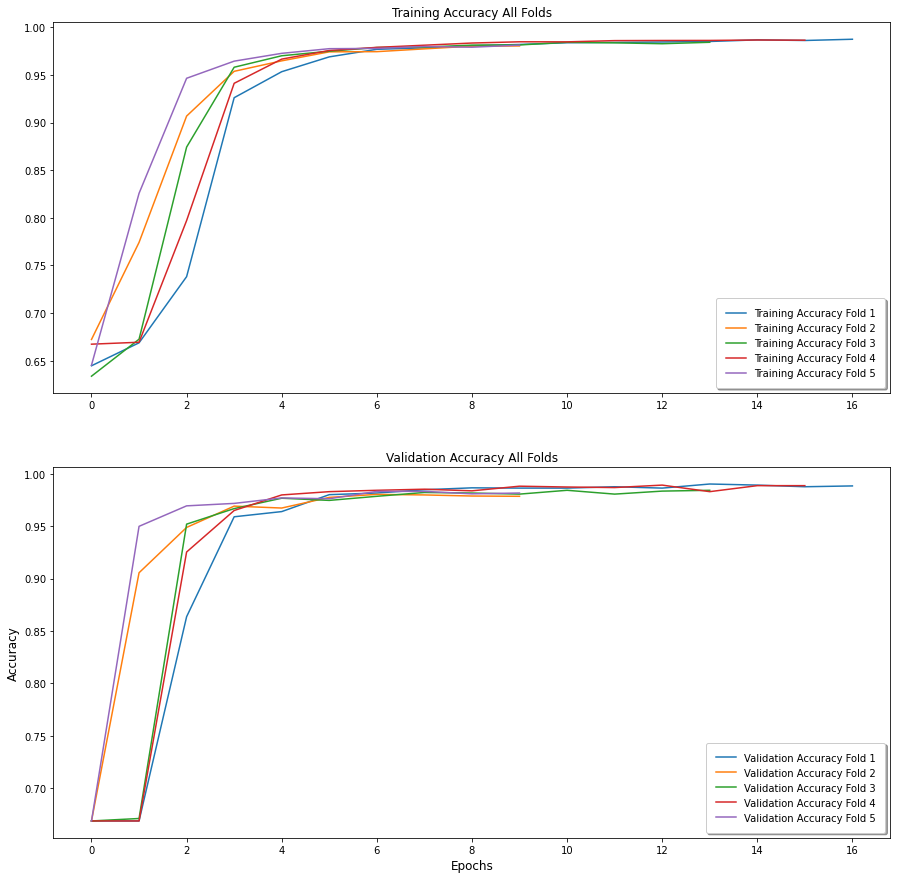

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15)) 

axs[0].plot(all_history['history-fold-1'].history['accuracy'], label = 'Training Accuracy Fold 1')
axs[0].plot(all_history['history-fold-2'].history['accuracy'], label = 'Training Accuracy Fold 2')
axs[0].plot(all_history['history-fold-3'].history['accuracy'], label = 'Training Accuracy Fold 3')
axs[0].plot(all_history['history-fold-4'].history['accuracy'], label = 'Training Accuracy Fold 4')
axs[0].plot(all_history['history-fold-5'].history['accuracy'], label = 'Training Accuracy Fold 5')

axs[0].title.set_text('Training Accuracy All Folds')
axs[0].legend(loc='lower right', fancybox=True, framealpha=1, shadow=True, borderpad=1)

axs[1].plot(all_history['history-fold-1'].history['val_accuracy'], label = 'Validation Accuracy Fold 1')
axs[1].plot(all_history['history-fold-2'].history['val_accuracy'], label = 'Validation Accuracy Fold 2')
axs[1].plot(all_history['history-fold-3'].history['val_accuracy'], label = 'Validation Accuracy Fold 3')
axs[1].plot(all_history['history-fold-4'].history['val_accuracy'], label = 'Validation Accuracy Fold 4')
axs[1].plot(all_history['history-fold-5'].history['val_accuracy'], label = 'Validation Accuracy Fold 5')

axs[1].title.set_text('Validation Accuracy All Folds')
axs[1].legend(loc='lower right', fancybox=True, framealpha=1, shadow=True, borderpad=1)  

plt.ylabel("Accuracy", fontsize = 12)
plt.xlabel("Epochs", fontsize = 12)


Text(0.5, 0, 'Epochs')

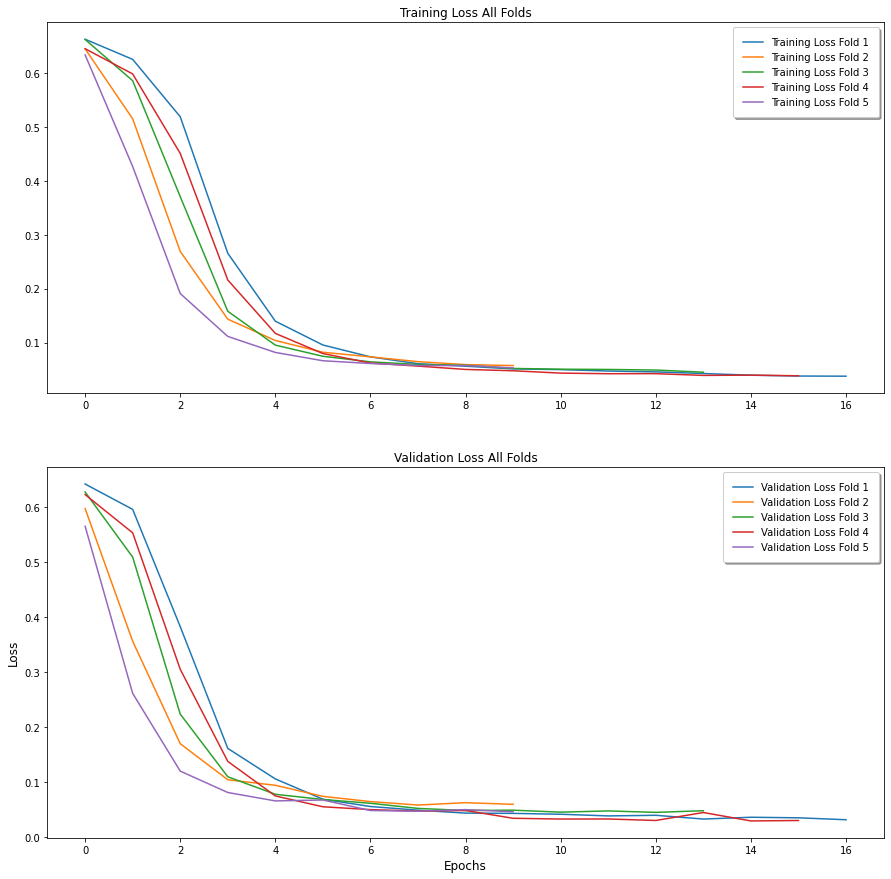

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15)) 

axs[0].plot(all_history['history-fold-1'].history['loss'], label = 'Training Loss Fold 1')
axs[0].plot(all_history['history-fold-2'].history['loss'], label = 'Training Loss Fold 2')
axs[0].plot(all_history['history-fold-3'].history['loss'], label = 'Training Loss Fold 3')
axs[0].plot(all_history['history-fold-4'].history['loss'], label = 'Training Loss Fold 4')
axs[0].plot(all_history['history-fold-5'].history['loss'], label = 'Training Loss Fold 5')

axs[0].title.set_text('Training Loss All Folds')
axs[0].legend(loc='upper right', fancybox=True, framealpha=1, shadow=True, borderpad=1)

axs[1].plot(all_history['history-fold-1'].history['val_loss'], label = 'Validation Loss Fold 1')
axs[1].plot(all_history['history-fold-2'].history['val_loss'], label = 'Validation Loss Fold 2')
axs[1].plot(all_history['history-fold-3'].history['val_loss'], label = 'Validation Loss Fold 3')
axs[1].plot(all_history['history-fold-4'].history['val_loss'], label = 'Validation Loss Fold 4')
axs[1].plot(all_history['history-fold-5'].history['val_loss'], label = 'Validation Loss Fold 5')

axs[1].title.set_text('Validation Loss All Folds')
axs[1].legend(loc='upper right', fancybox=True, framealpha=1, shadow=True, borderpad=1)  

plt.ylabel("Loss", fontsize = 12)
plt.xlabel("Epochs", fontsize = 12)

Text(0.5, 0, 'Epochs')

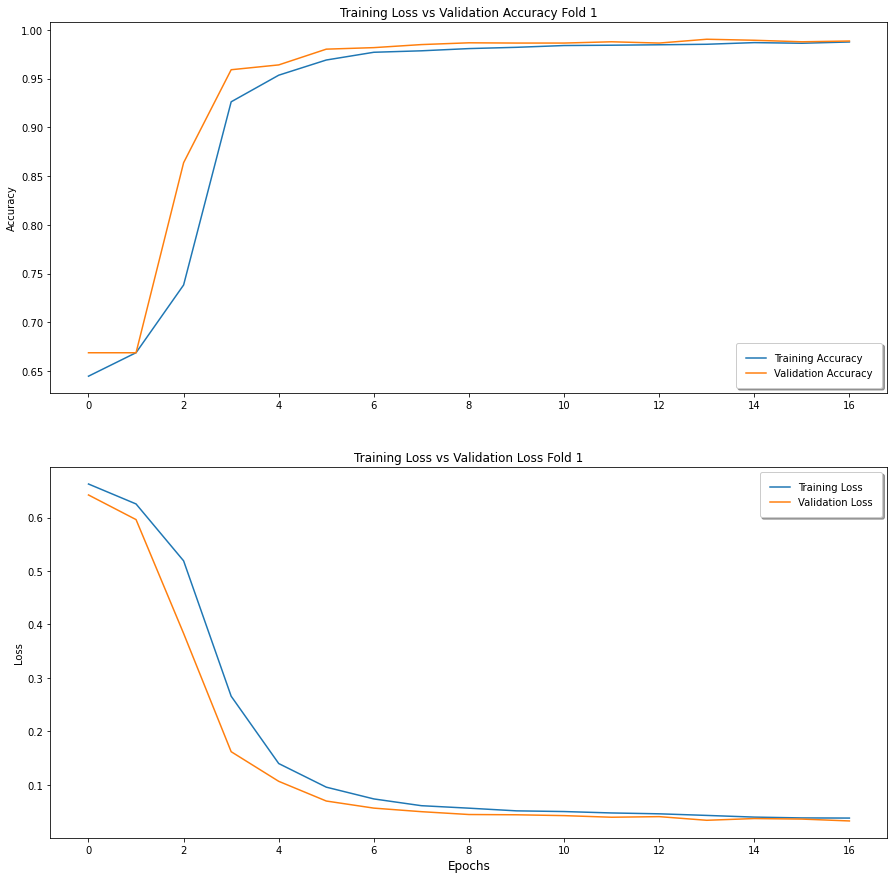

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15)) 

axs[0].plot(all_history['history-fold-1'].history['accuracy'], label = 'Training Accuracy')
axs[0].plot(all_history['history-fold-1'].history['val_accuracy'], label = 'Validation Accuracy')
axs[0].title.set_text('Training Loss vs Validation Accuracy Fold 1')
axs[0].legend(loc='lower right', fancybox=True, framealpha=1, shadow=True, borderpad=1)


axs[1].plot(all_history['history-fold-1'].history['loss'], label = 'Training Loss')
axs[1].plot(all_history['history-fold-1'].history['val_loss'], label = 'Validation Loss')
axs[1].title.set_text('Training Loss vs Validation Loss Fold 1')
axs[1].legend(loc='upper right', fancybox=True, framealpha=1, shadow=True, borderpad=1)  


plt.setp(axs[0], ylabel='Accuracy')
plt.setp(axs[1], ylabel='Loss')
plt.xlabel("Epochs", fontsize = 12)


Text(0.5, 0, 'Epochs')

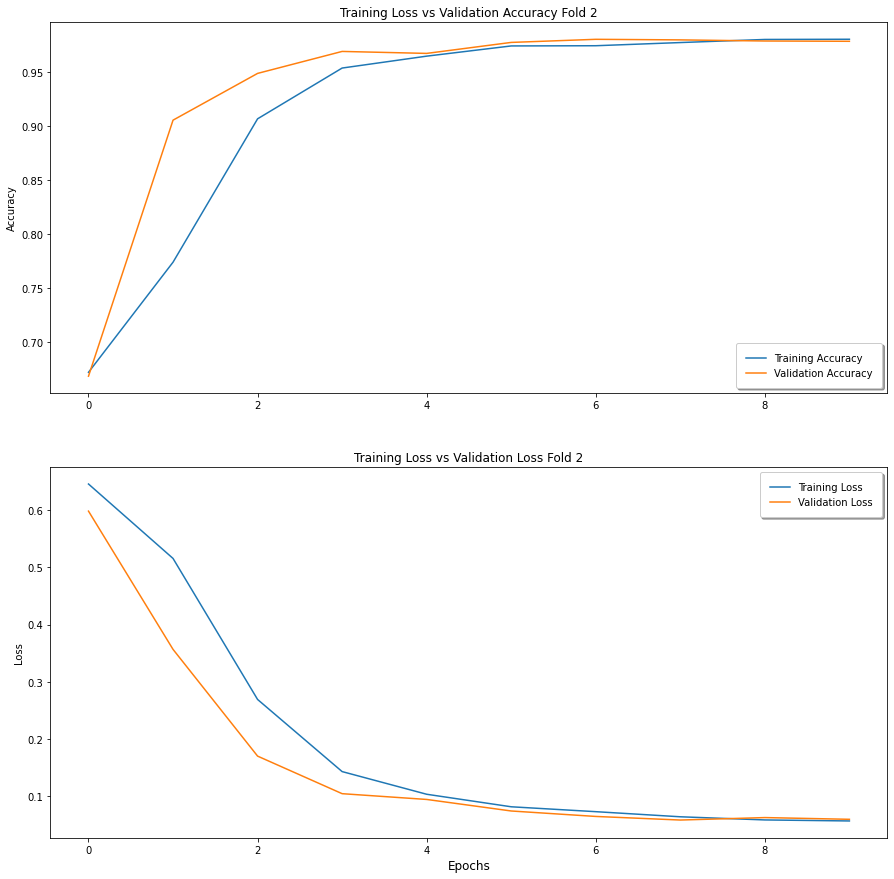

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15)) 

axs[0].plot(all_history['history-fold-2'].history['accuracy'], label = 'Training Accuracy')
axs[0].plot(all_history['history-fold-2'].history['val_accuracy'], label = 'Validation Accuracy')
axs[0].title.set_text('Training Loss vs Validation Accuracy Fold 2')
axs[0].legend(loc='lower right', fancybox=True, framealpha=1, shadow=True, borderpad=1)


axs[1].plot(all_history['history-fold-2'].history['loss'], label = 'Training Loss')
axs[1].plot(all_history['history-fold-2'].history['val_loss'], label = 'Validation Loss')
axs[1].title.set_text('Training Loss vs Validation Loss Fold 2')
axs[1].legend(loc='upper right', fancybox=True, framealpha=1, shadow=True, borderpad=1)   


plt.setp(axs[0], ylabel='Accuracy')
plt.setp(axs[1], ylabel='Loss')
plt.xlabel("Epochs", fontsize = 12)


Text(0.5, 0, 'Epochs')

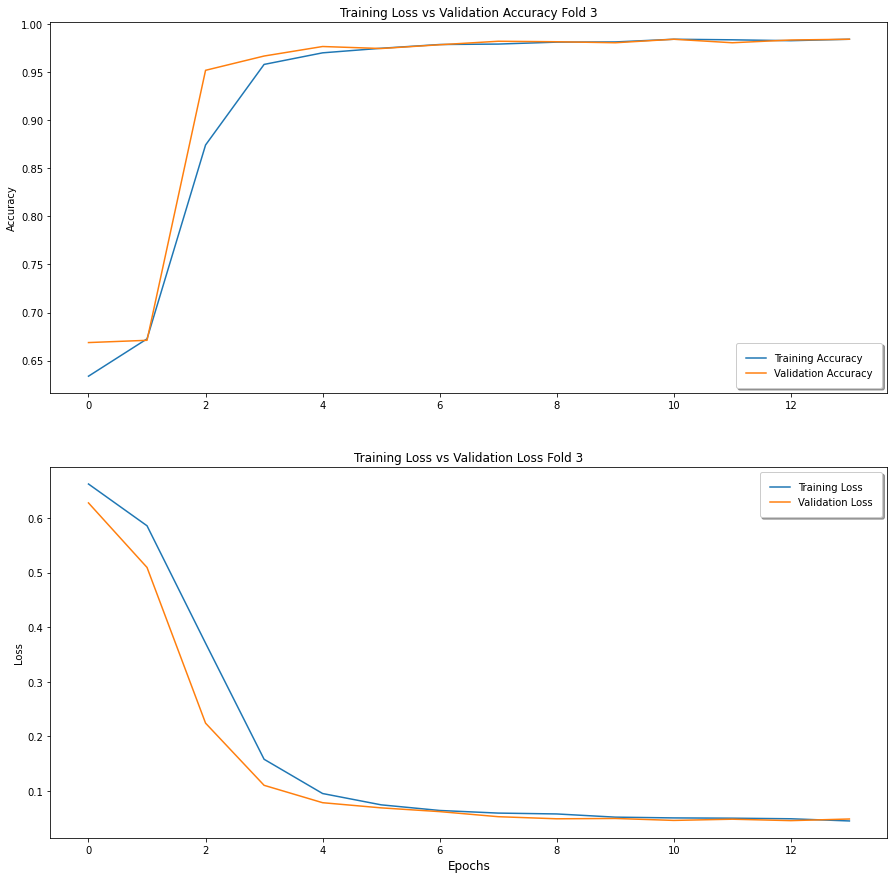

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15)) 

axs[0].plot(all_history['history-fold-3'].history['accuracy'], label = 'Training Accuracy')
axs[0].plot(all_history['history-fold-3'].history['val_accuracy'], label = 'Validation Accuracy')
axs[0].title.set_text('Training Loss vs Validation Accuracy Fold 3')
axs[0].legend(loc='lower right', fancybox=True, framealpha=1, shadow=True, borderpad=1)


axs[1].plot(all_history['history-fold-3'].history['loss'], label = 'Training Loss')
axs[1].plot(all_history['history-fold-3'].history['val_loss'], label = 'Validation Loss')
axs[1].title.set_text('Training Loss vs Validation Loss Fold 3')
axs[1].legend(loc='upper right', fancybox=True, framealpha=1, shadow=True, borderpad=1)  


plt.setp(axs[0], ylabel='Accuracy')
plt.setp(axs[1], ylabel='Loss')
plt.xlabel("Epochs", fontsize = 12)


Text(0.5, 0, 'Epochs')

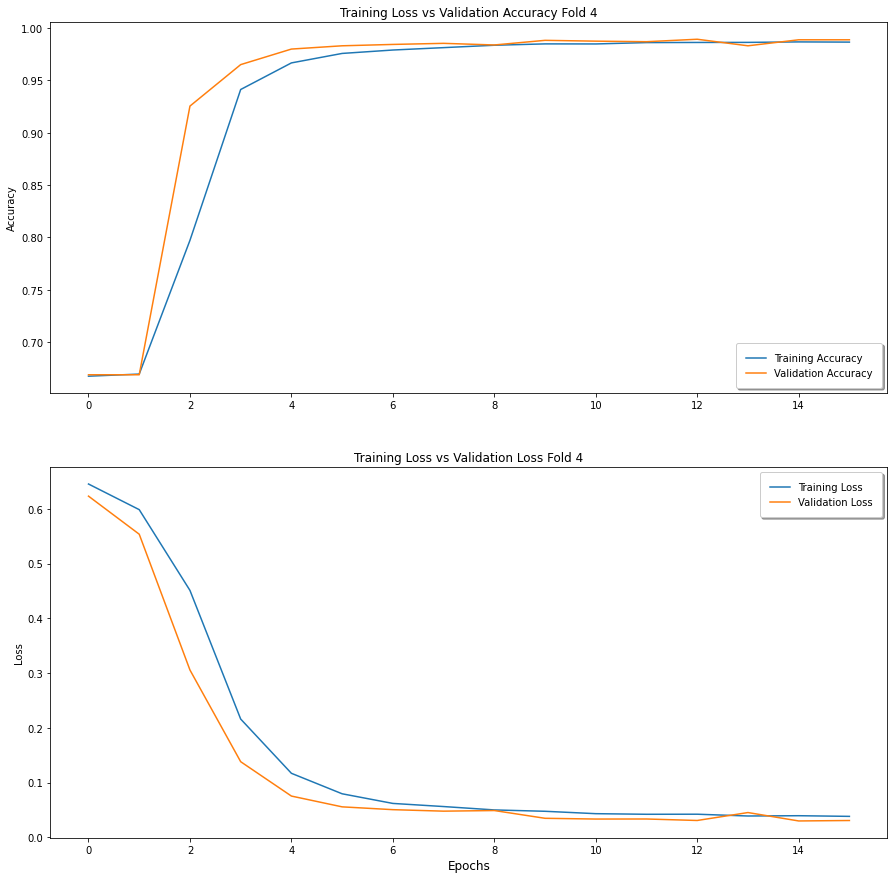

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15)) 

axs[0].plot(all_history['history-fold-4'].history['accuracy'], label = 'Training Accuracy')
axs[0].plot(all_history['history-fold-4'].history['val_accuracy'], label = 'Validation Accuracy')
axs[0].title.set_text('Training Loss vs Validation Accuracy Fold 4')
axs[0].legend(loc='lower right', fancybox=True, framealpha=1, shadow=True, borderpad=1)


axs[1].plot(all_history['history-fold-4'].history['loss'], label = 'Training Loss')
axs[1].plot(all_history['history-fold-4'].history['val_loss'], label = 'Validation Loss')
axs[1].title.set_text('Training Loss vs Validation Loss Fold 4')
axs[1].legend(loc='upper right', fancybox=True, framealpha=1, shadow=True, borderpad=1)  


plt.setp(axs[0], ylabel='Accuracy')
plt.setp(axs[1], ylabel='Loss')
plt.xlabel("Epochs", fontsize = 12)


Text(0.5, 0, 'Epochs')

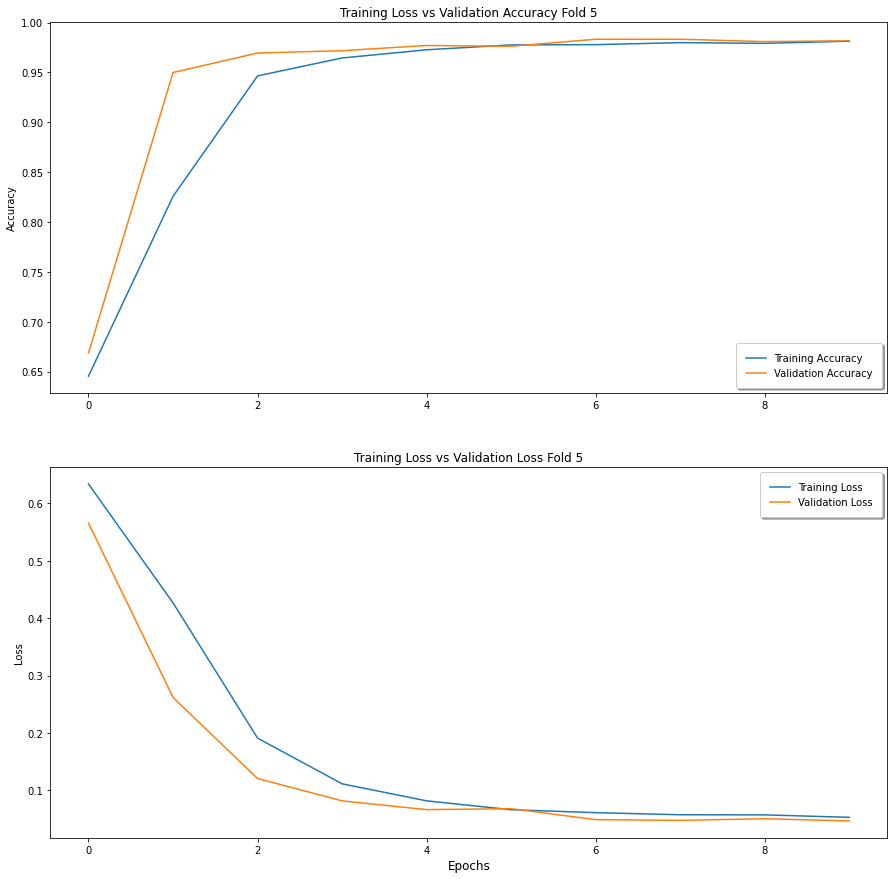

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15)) 

axs[0].plot(all_history['history-fold-5'].history['accuracy'], label = 'Training Accuracy')
axs[0].plot(all_history['history-fold-5'].history['val_accuracy'], label = 'Validation Accuracy')
axs[0].title.set_text('Training Loss vs Validation Accuracy Fold 5')
axs[0].legend(loc='lower right', fancybox=True, framealpha=1, shadow=True, borderpad=1)


axs[1].plot(all_history['history-fold-5'].history['loss'], label = 'Training Loss')
axs[1].plot(all_history['history-fold-5'].history['val_loss'], label = 'Validation Loss')
axs[1].title.set_text('Training Loss vs Validation Loss Fold 5')
axs[1].legend(loc='upper right', fancybox=True, framealpha=1, shadow=True, borderpad=1)  


plt.setp(axs[0], ylabel='Accuracy')
plt.setp(axs[1], ylabel='Loss')
plt.xlabel("Epochs", fontsize = 12)


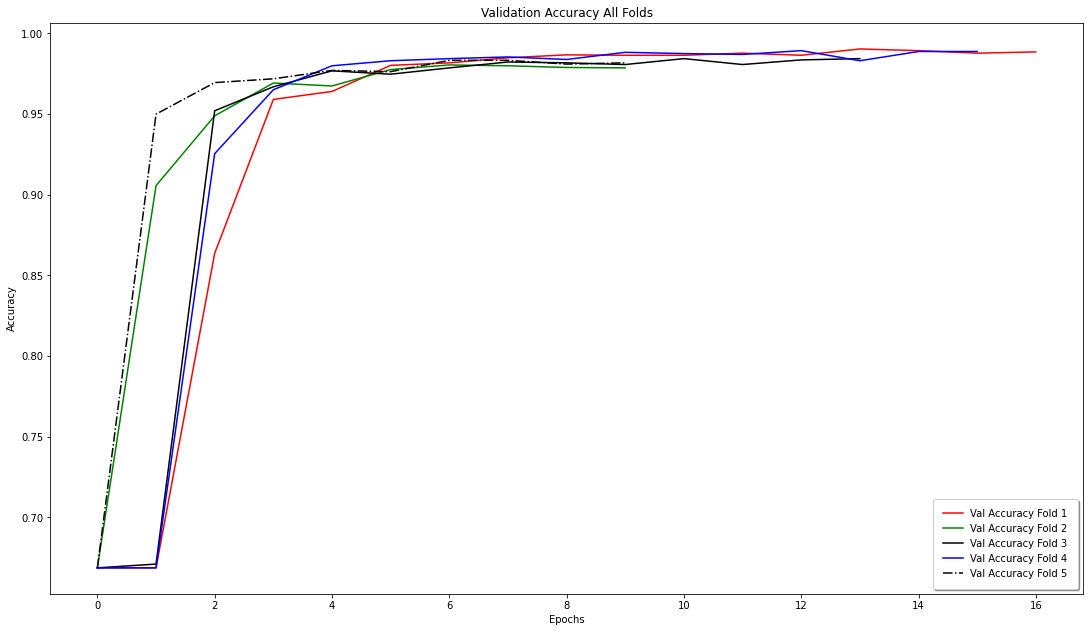

In [ ]:
# fig, axs = plt.subplots(2, 1, figsize=(15,15)) 

plt.title('Validation Accuracy All Folds')
plt.plot(all_history['history-fold-1'].history['val_accuracy'], label='Val Accuracy Fold 1', color='red')
plt.plot(all_history['history-fold-2'].history['val_accuracy'], label='Val Accuracy Fold 2', color='green')
plt.plot(all_history['history-fold-3'].history['val_accuracy'], label='Val Accuracy Fold 3', color='black')
plt.plot(all_history['history-fold-4'].history['val_accuracy'], label='Val Accuracy Fold 4', color='blue')
plt.plot(all_history['history-fold-5'].history['val_accuracy'], label='Val Accuracy Fold 5', color='black', linestyle = "dashdot")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.legend(loc='lower right', fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

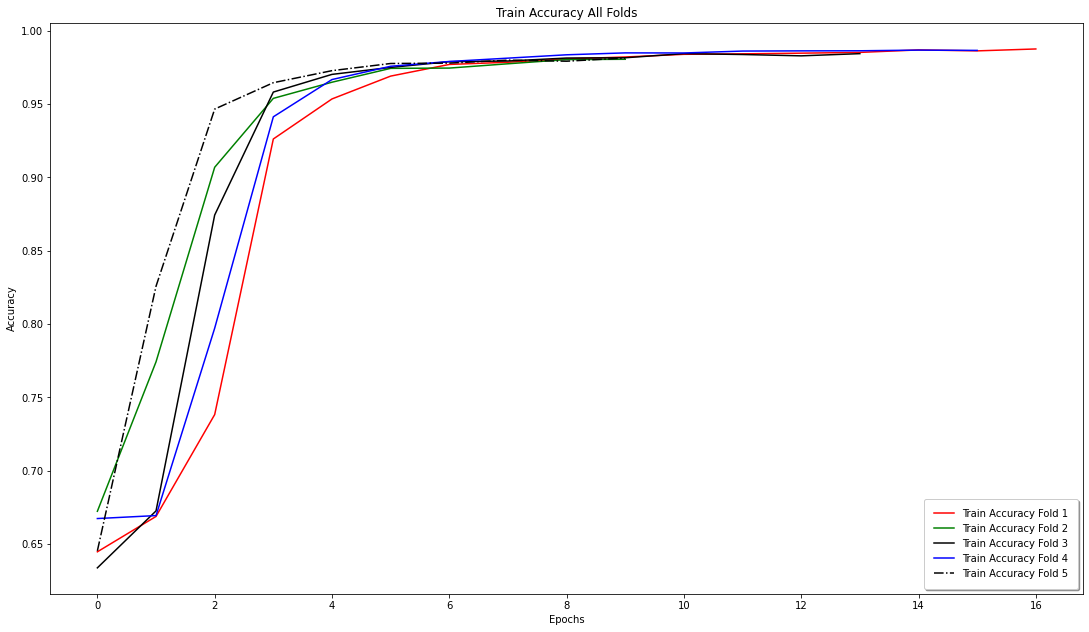

In [ ]:
plt.title('Train Accuracy All Folds')
plt.plot(all_history['history-fold-1'].history['accuracy'], label='Train Accuracy Fold 1', color='red')
plt.plot(all_history['history-fold-2'].history['accuracy'], label='Train Accuracy Fold 2', color='green')
plt.plot(all_history['history-fold-3'].history['accuracy'], label='Train Accuracy Fold 3', color='black')
plt.plot(all_history['history-fold-4'].history['accuracy'], label='Train Accuracy Fold 4', color='blue')
plt.plot(all_history['history-fold-5'].history['accuracy'], label='Train Accuracy Fold 5', color='black', linestyle = "dashdot")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.legend(loc='lower right', fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

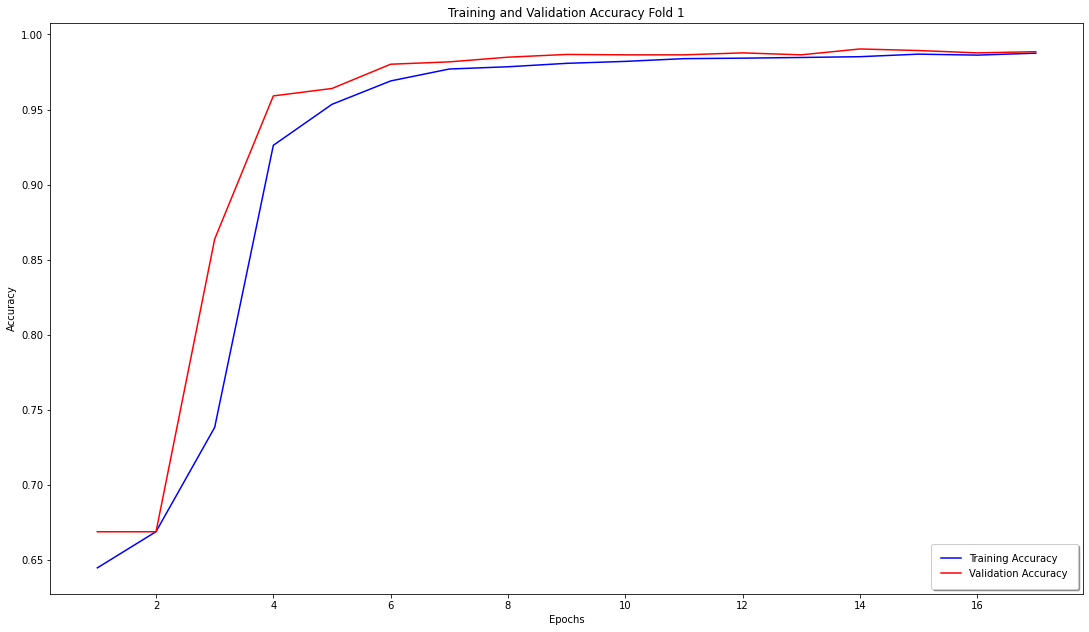

In [ ]:
history = all_history['history-fold-1'].history
loss_values = history["accuracy"]
val_loss_values = history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "b", label="Training Accuracy")
plt.plot(epochs, val_loss_values, "r", label="Validation Accuracy")
plt.title("Training and Validation Accuracy Fold 1")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.legend(loc='lower right', fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

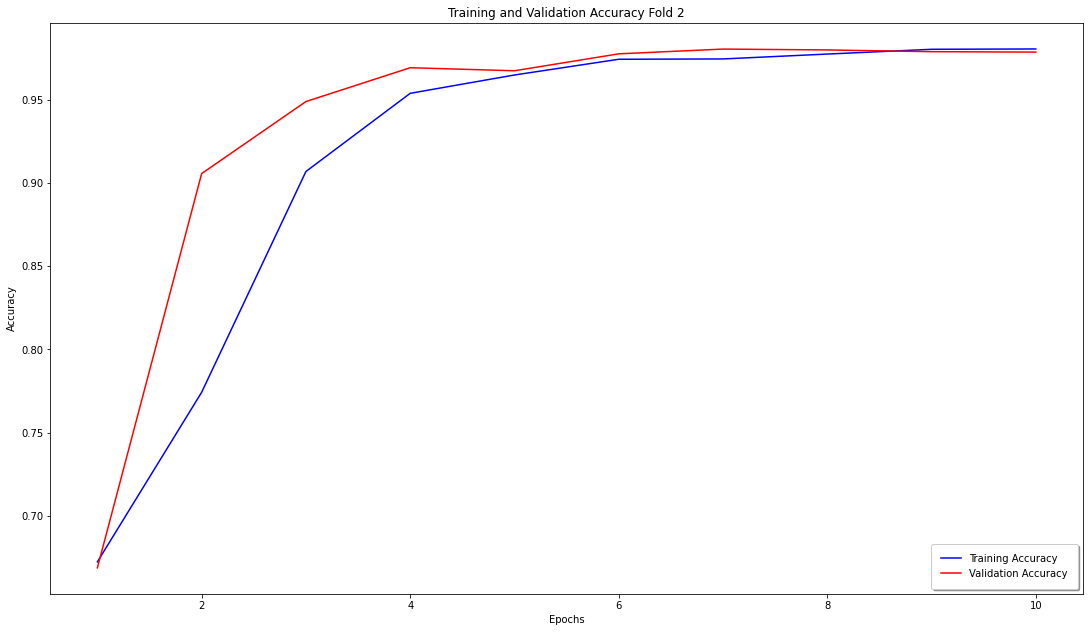

In [ ]:
history = all_history['history-fold-2'].history
loss_values = history["accuracy"]
val_loss_values = history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "b", label="Training Accuracy")
plt.plot(epochs, val_loss_values, "r", label="Validation Accuracy")
plt.title("Training and Validation Accuracy Fold 2")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.legend(loc='lower right', fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

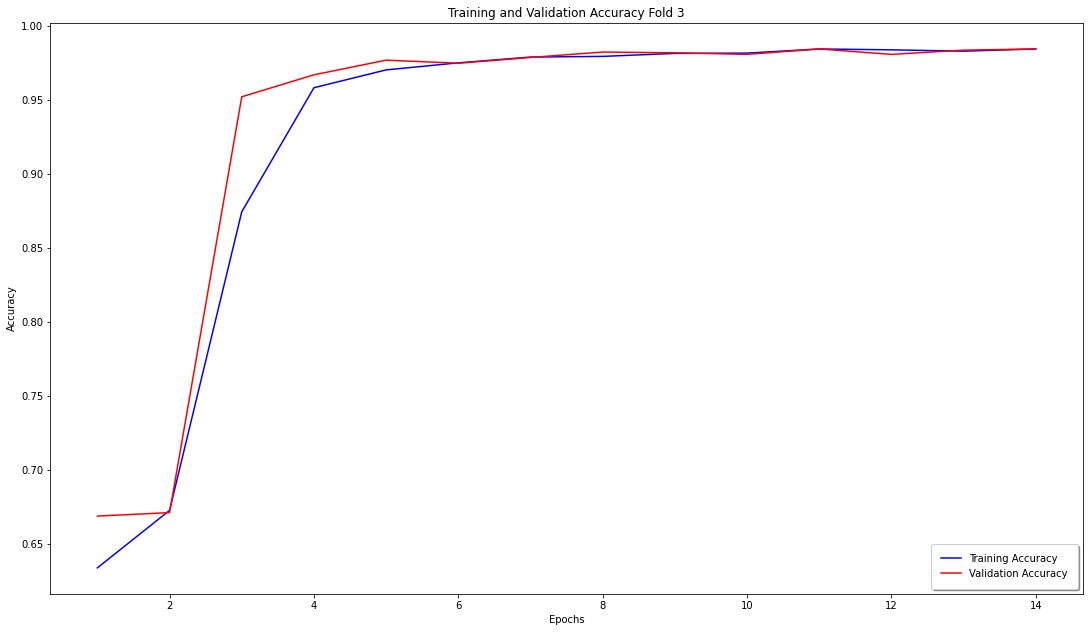

In [ ]:
history = all_history['history-fold-3'].history
loss_values = history["accuracy"]
val_loss_values = history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "b", label="Training Accuracy")
plt.plot(epochs, val_loss_values, "r", label="Validation Accuracy")
plt.title("Training and Validation Accuracy Fold 3")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.legend(loc='lower right', fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

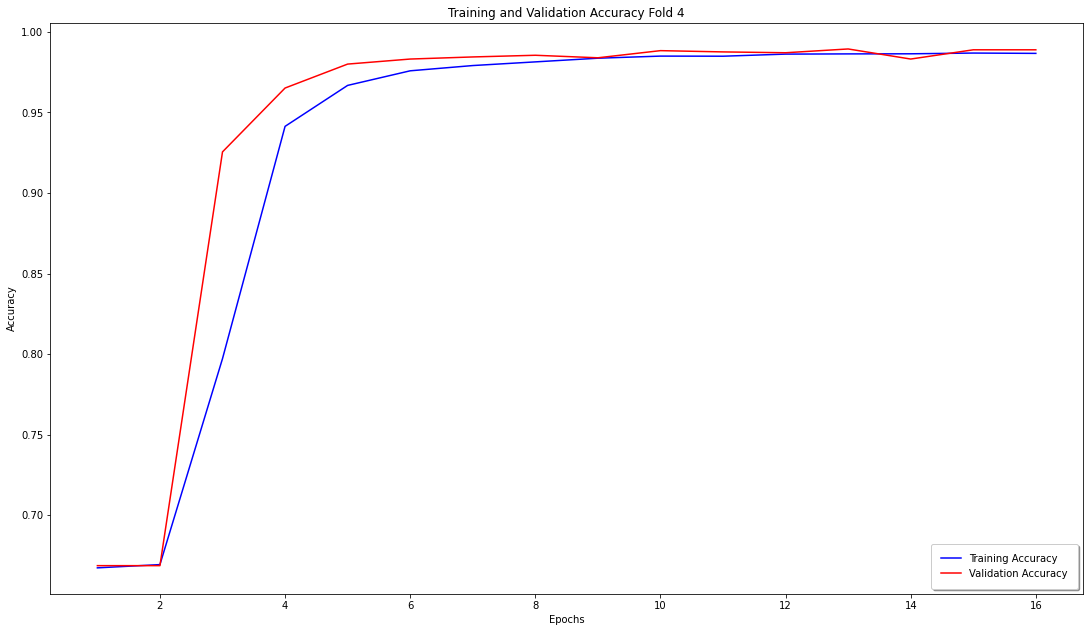

In [ ]:
history = all_history['history-fold-4'].history
loss_values = history["accuracy"]
val_loss_values = history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "b", label="Training Accuracy")
plt.plot(epochs, val_loss_values, "r", label="Validation Accuracy")
plt.title("Training and Validation Accuracy Fold 4")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.legend(loc='lower right', fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

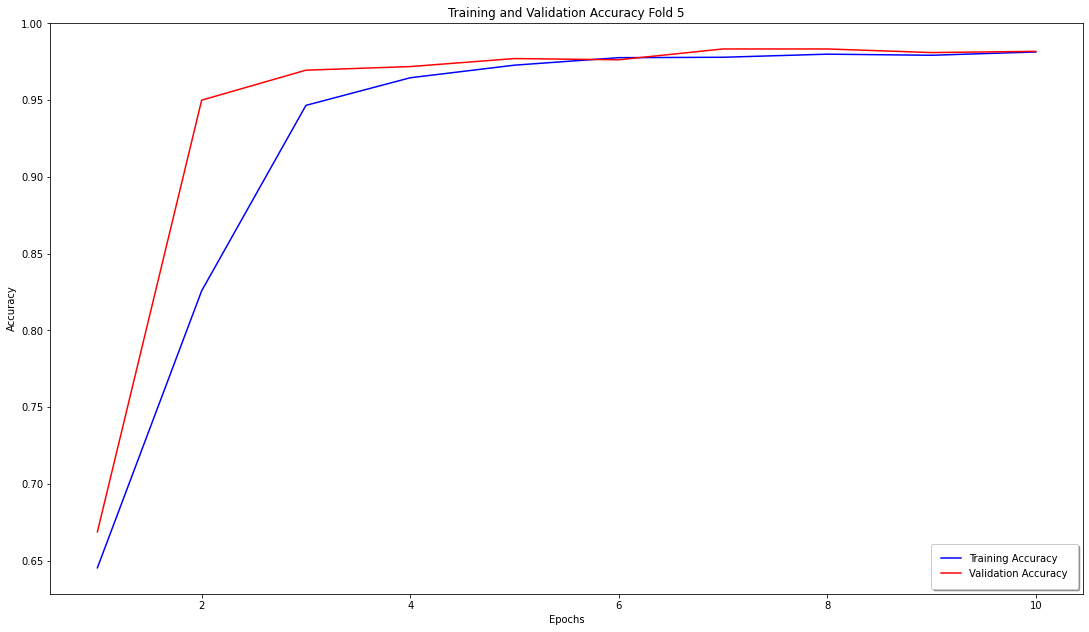

In [ ]:
history = all_history['history-fold-5'].history
loss_values = history["accuracy"]
val_loss_values = history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "b", label="Training Accuracy")
plt.plot(epochs, val_loss_values, "r", label="Validation Accuracy")
plt.title("Training and Validation Accuracy Fold 5")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.legend(loc='lower right', fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

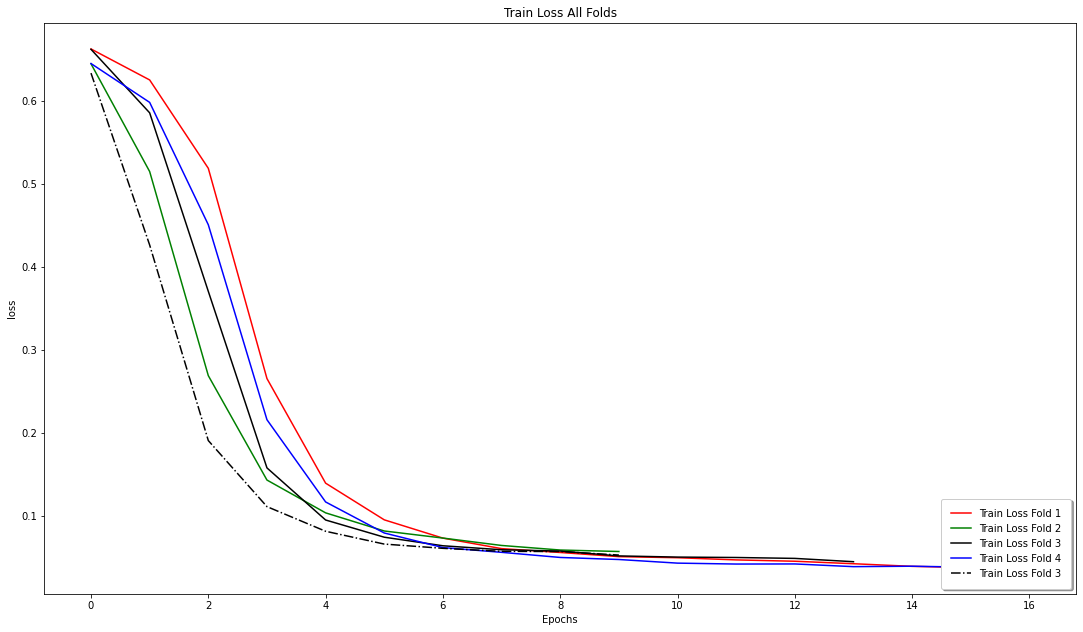

In [ ]:
plt.title('Train Loss All Folds')
plt.plot(all_history['history-fold-1'].history['loss'], label='Train Loss Fold 1', color='red')
plt.plot(all_history['history-fold-2'].history['loss'], label='Train Loss Fold 2', color='green')
plt.plot(all_history['history-fold-3'].history['loss'], label='Train Loss Fold 3', color='black')
plt.plot(all_history['history-fold-4'].history['loss'], label='Train Loss Fold 4', color='blue')
plt.plot(all_history['history-fold-5'].history['loss'], label='Train Loss Fold 3', color='black', linestyle = "dashdot")

plt.xlabel("Epochs")
plt.ylabel("loss")

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.legend(loc='lower right', fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

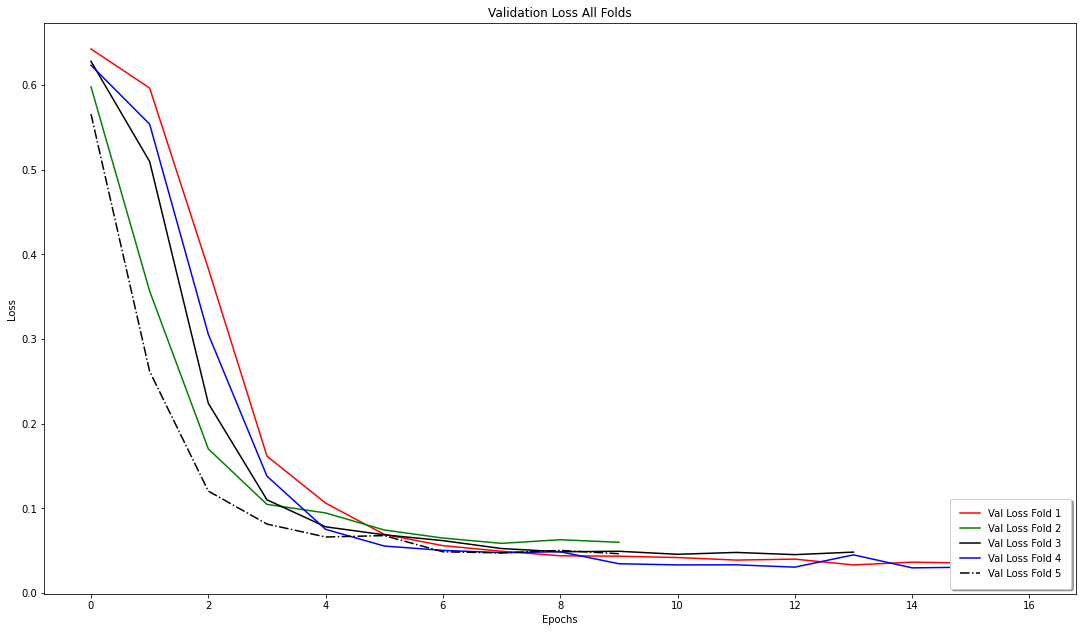

In [ ]:
plt.title('Validation Loss All Folds')
plt.plot(all_history['history-fold-1'].history['val_loss'], label='Val Loss Fold 1', color='red')
plt.plot(all_history['history-fold-2'].history['val_loss'], label='Val Loss Fold 2', color='green')
plt.plot(all_history['history-fold-3'].history['val_loss'], label='Val Loss Fold 3', color='black')
plt.plot(all_history['history-fold-4'].history['val_loss'], label='Val Loss Fold 4', color='blue')
plt.plot(all_history['history-fold-5'].history['val_loss'], label='Val Loss Fold 5', color='black', linestyle = "dashdot")

plt.xlabel("Epochs")
plt.ylabel("Loss")

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.legend(loc='lower right', fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

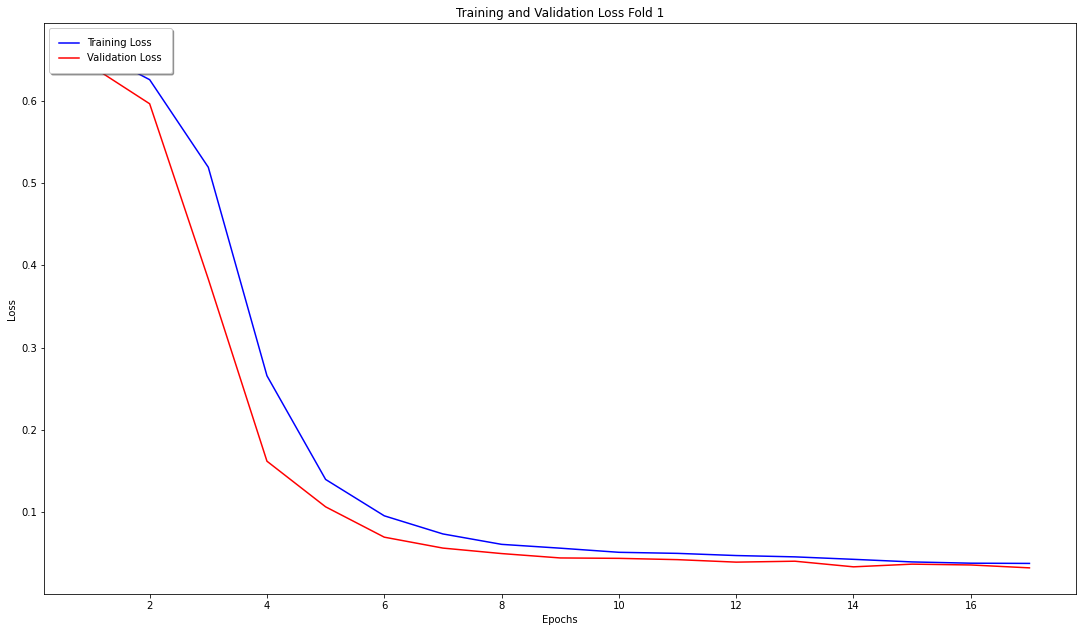

In [ ]:
history = all_history['history-fold-1'].history
loss_values = history["loss"]
val_loss_values = history["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "b", label="Training Loss")
plt.plot(epochs, val_loss_values, "r", label="Validation Loss")
plt.title("Training and Validation Loss Fold 1")
plt.xlabel("Epochs")
plt.ylabel("Loss")

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.legend(loc='upper left', fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

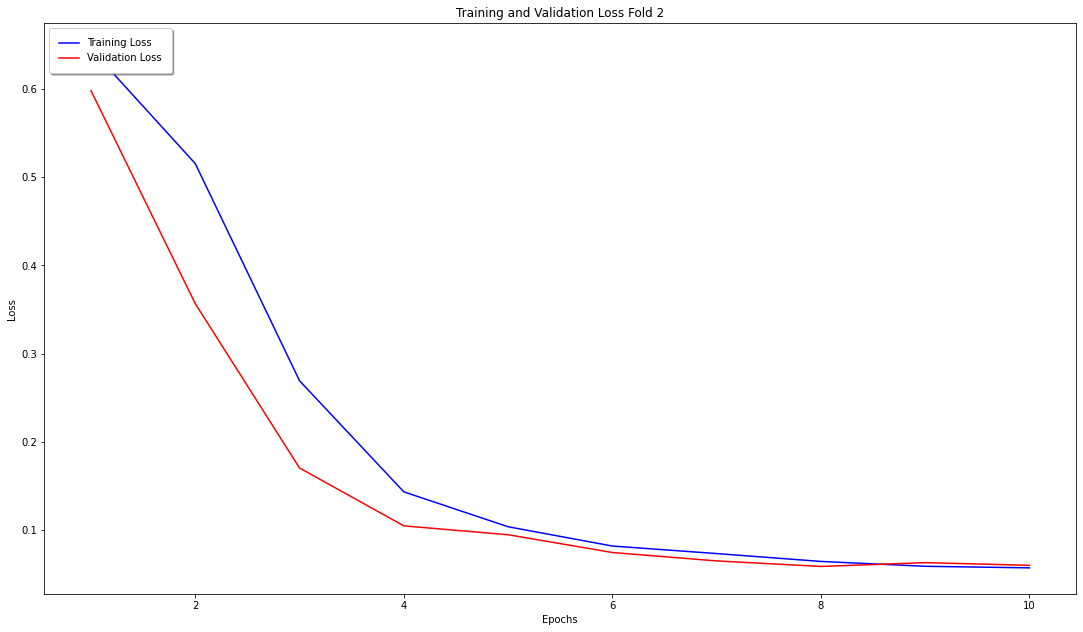

In [ ]:
history = all_history['history-fold-2'].history
loss_values = history["loss"]
val_loss_values = history["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "b", label="Training Loss")
plt.plot(epochs, val_loss_values, "r", label="Validation Loss")
plt.title("Training and Validation Loss Fold 2")
plt.xlabel("Epochs")
plt.ylabel("Loss")

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.legend(loc='upper left', fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

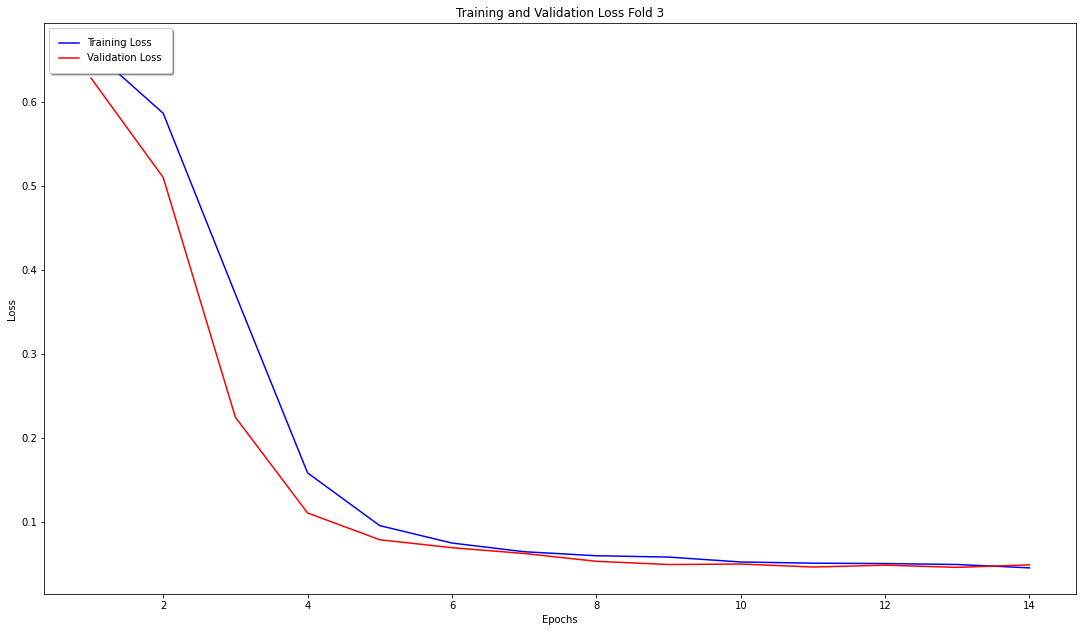

In [ ]:
history = all_history['history-fold-3'].history
loss_values = history["loss"]
val_loss_values = history["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "b", label="Training Loss")
plt.plot(epochs, val_loss_values, "r", label="Validation Loss")
plt.title("Training and Validation Loss Fold 3")
plt.xlabel("Epochs")
plt.ylabel("Loss")

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.legend(loc='upper left', fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

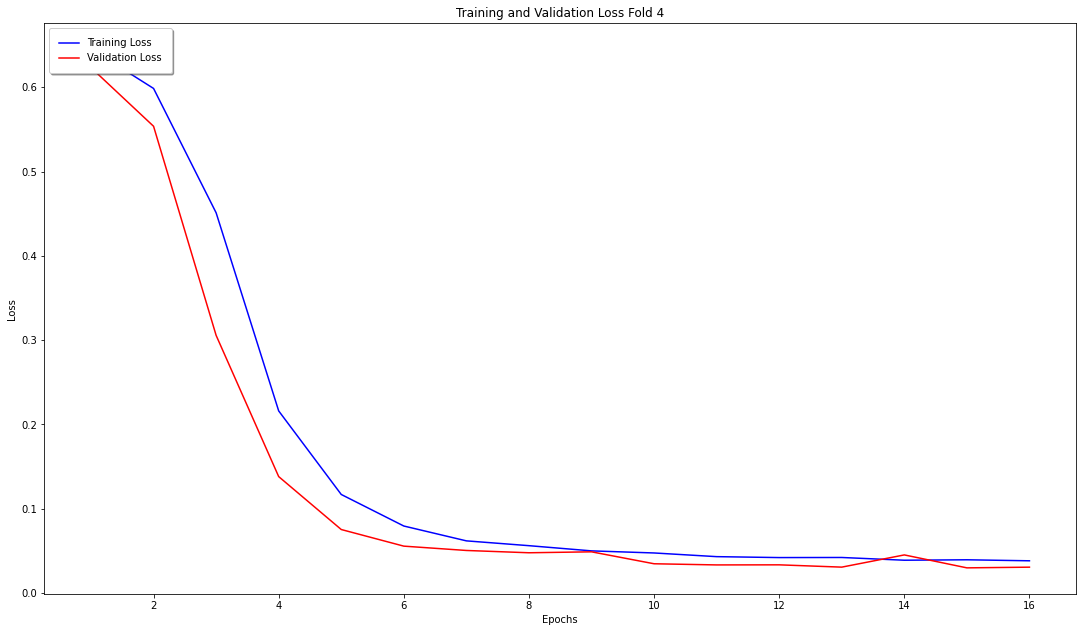

In [ ]:
history = all_history['history-fold-4'].history
loss_values = history["loss"]
val_loss_values = history["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "b", label="Training Loss")
plt.plot(epochs, val_loss_values, "r", label="Validation Loss")
plt.title("Training and Validation Loss Fold 4")
plt.xlabel("Epochs")
plt.ylabel("Loss")

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.legend(loc='upper left', fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

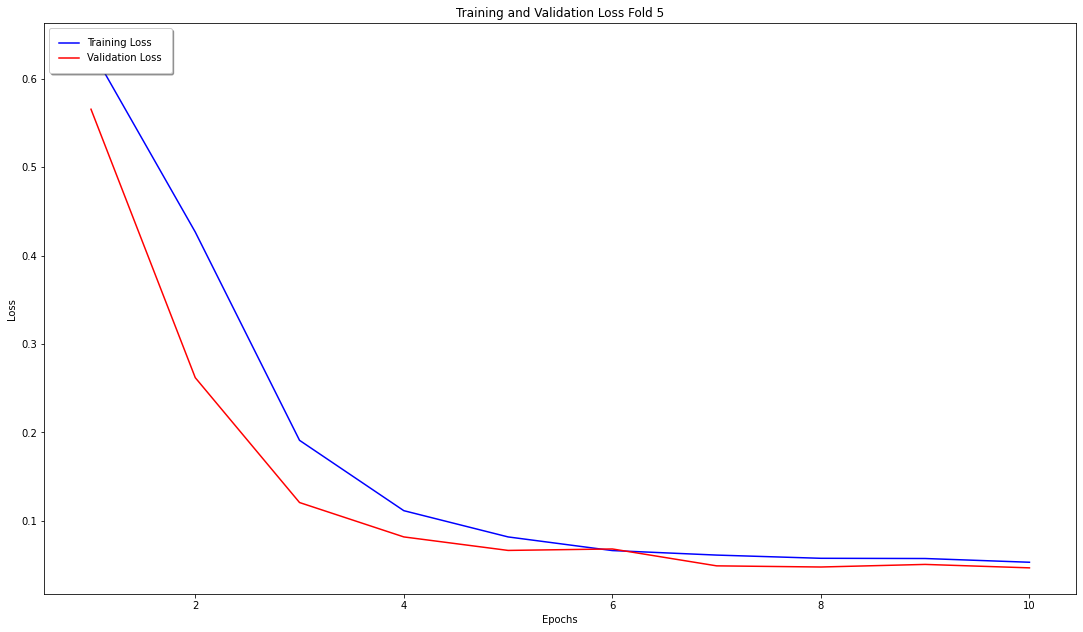

In [ ]:
history = all_history['history-fold-5'].history
loss_values = history["loss"]
val_loss_values = history["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "b", label="Training Loss")
plt.plot(epochs, val_loss_values, "r", label="Validation Loss")
plt.title("Training and Validation Loss Fold 5")
plt.xlabel("Epochs")
plt.ylabel("Loss")

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.legend(loc='upper left', fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

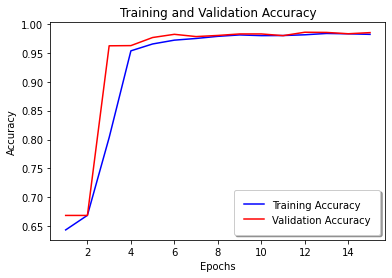

In [ ]:
# history = all_history['history-fold-1'].history
# loss_values = history["accuracy"]
# val_loss_values = history["val_accuracy"]
# epochs = range(1, len(loss_values) + 1)
# plt.plot(epochs, loss_values, "b", label="Training Accuracy")
# plt.plot(epochs, val_loss_values, "r", label="Validation Accuracy")
# #plt.axvline(8, label="Optimal Model Epoch = 8")
# plt.title("Training and Validation Accuracy")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend(loc='lower right', fancybox=True, framealpha=1, shadow=True, borderpad=1)
# plt.show()

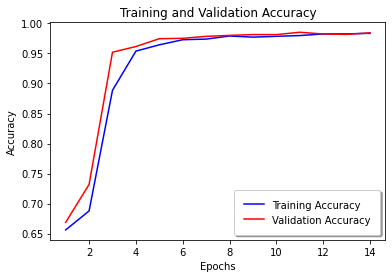

In [ ]:
# history = all_history['history-fold-2'].history
# loss_values = history["accuracy"]
# val_loss_values = history["val_accuracy"]
# epochs = range(1, len(loss_values) + 1)
# plt.plot(epochs, loss_values, "b", label="Training Accuracy")
# plt.plot(epochs, val_loss_values, "r", label="Validation Accuracy")
# #plt.axvline(8, label="Optimal Model Epoch = 8")
# plt.title("Training and Validation Accuracy")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend(loc='lower right', fancybox=True, framealpha=1, shadow=True, borderpad=1)
# plt.show()

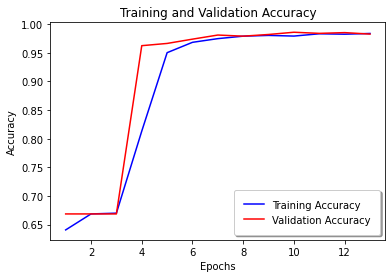

In [ ]:
# history = all_history['history-fold-3'].history
# loss_values = history["accuracy"]
# val_loss_values = history["val_accuracy"]
# epochs = range(1, len(loss_values) + 1)
# plt.plot(epochs, loss_values, "b", label="Training Accuracy")
# plt.plot(epochs, val_loss_values, "r", label="Validation Accuracy")
# #plt.axvline(8, label="Optimal Model Epoch = 8")
# plt.title("Training and Validation Accuracy")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend(loc='lower right', fancybox=True, framealpha=1, shadow=True, borderpad=1)
# plt.show()

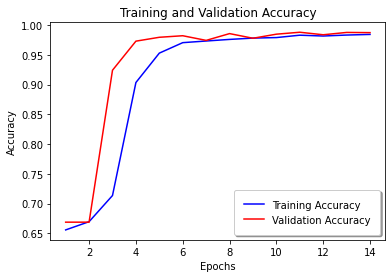

In [ ]:
# history = all_history['history-fold-4'].history
# loss_values = history["accuracy"]
# val_loss_values = history["val_accuracy"]
# epochs = range(1, len(loss_values) + 1)
# plt.plot(epochs, loss_values, "b", label="Training Accuracy")
# plt.plot(epochs, val_loss_values, "r", label="Validation Accuracy")
# #plt.axvline(8, label="Optimal Model Epoch = 8")
# plt.title("Training and Validation Accuracy")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend(loc='lower right', fancybox=True, framealpha=1, shadow=True, borderpad=1)
# plt.show()

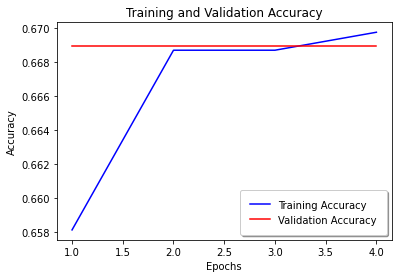

In [ ]:
# history = all_history['history-fold-5'].history
# loss_values = history["accuracy"]
# val_loss_values = history["val_accuracy"]
# epochs = range(1, len(loss_values) + 1)
# plt.plot(epochs, loss_values, "b", label="Training Accuracy")
# plt.plot(epochs, val_loss_values, "r", label="Validation Accuracy")
# #plt.axvline(8, label="Optimal Model Epoch = 8")
# plt.title("Training and Validation Accuracy")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend(loc='lower right', fancybox=True, framealpha=1, shadow=True, borderpad=1)
# plt.show()

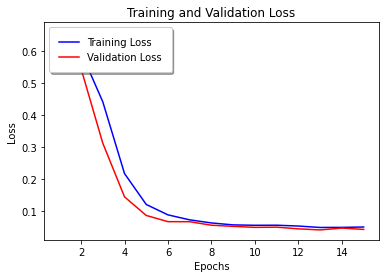

In [ ]:
# history = all_history['history-fold-1'].history
# loss_values = history["loss"]
# val_loss_values = history["val_loss"]
# epochs = range(1, len(loss_values) + 1)
# plt.plot(epochs, loss_values, "b", label="Training Loss")
# plt.plot(epochs, val_loss_values, "r", label="Validation Loss")
# #plt.axvline(8, label="Optimal Model Epoch = 8")
# plt.title("Training and Validation Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend(loc='upper left', fancybox=True, framealpha=1, shadow=True, borderpad=1)
# plt.show()

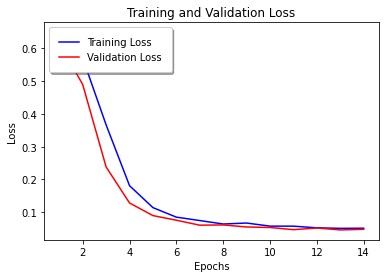

In [ ]:
# history = all_history['history-fold-2'].history
# loss_values = history["loss"]
# val_loss_values = history["val_loss"]
# epochs = range(1, len(loss_values) + 1)
# plt.plot(epochs, loss_values, "b", label="Training Loss")
# plt.plot(epochs, val_loss_values, "r", label="Validation Loss")
# #plt.axvline(8, label="Optimal Model Epoch = 8")
# plt.title("Training and Validation Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend(loc='upper left', fancybox=True, framealpha=1, shadow=True, borderpad=1)
# plt.show()

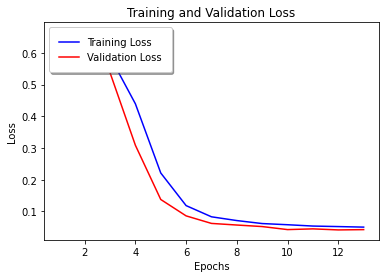

In [ ]:
# history = all_history['history-fold-3'].history
# loss_values = history["loss"]
# val_loss_values = history["val_loss"]
# epochs = range(1, len(loss_values) + 1)
# plt.plot(epochs, loss_values, "b", label="Training Loss")
# plt.plot(epochs, val_loss_values, "r", label="Validation Loss")
# #plt.axvline(8, label="Optimal Model Epoch = 8")
# plt.title("Training and Validation Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend(loc='upper left', fancybox=True, framealpha=1, shadow=True, borderpad=1)
# plt.show()

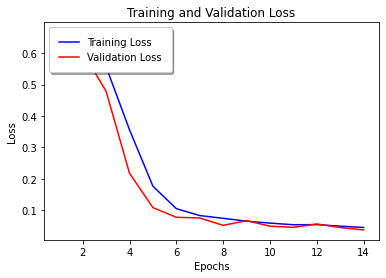

In [ ]:
# history = all_history['history-fold-4'].history
# loss_values = history["loss"]
# val_loss_values = history["val_loss"]
# epochs = range(1, len(loss_values) + 1)
# plt.plot(epochs, loss_values, "b", label="Training Loss")
# plt.plot(epochs, val_loss_values, "r", label="Validation Loss")
# #plt.axvline(8, label="Optimal Model Epoch = 8")
# plt.title("Training and Validation Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend(loc='upper left', fancybox=True, framealpha=1, shadow=True, borderpad=1)
# plt.show()

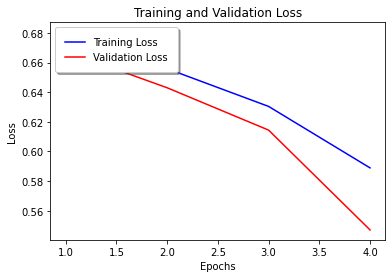

In [ ]:
# history = all_history['history-fold-5'].history
# loss_values = history["loss"]
# val_loss_values = history["val_loss"]
# epochs = range(1, len(loss_values) + 1)
# plt.plot(epochs, loss_values, "b", label="Training Loss")
# plt.plot(epochs, val_loss_values, "r", label="Validation Loss")
# #plt.axvline(8, label="Optimal Model Epoch = 8")
# plt.title("Training and Validation Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend(loc='upper left', fancybox=True, framealpha=1, shadow=True, borderpad=1)
# plt.show()

# Post-Processing

In [ ]:
model = keras.models.load_model('/content/drive/Shareddrives/ECEN 404 Machine Learning/Color/Final Model/New_Model_SGD_Saved_Model_1/best-model-kfold-3.hdf5')

Method 1

In [ ]:
test_directory = '/content/drive/Shareddrives/ECEN 404 Machine Learning/Color/Final Model/Test'

In [ ]:
test_data = []
classes = ["Healthy", "Yellow Leaf Curl"]
def create_test_data():
  for i in classes:
    path = os.path.join(test_directory, i)   # directory path for test rice images
    class_num = classes.index(i)
    for img in os.listdir(path):    # Include try catch? 10:18
      img_array = cv2.imread(os.path.join(path,img))
      img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)      
      img_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA)
      
      test_data.append([img_array, class_num])


create_test_data()

In [ ]:
X_test = []
y_test = []

In [ ]:
for img, classes in test_data:
  X_test.append(img)
  y_test.append(classes)

In [ ]:
X_test = np.array(X_test)
X_test.shape

(961, 256, 256, 3)

In [ ]:
X_test = X_test/255.0

In [ ]:
y_test = np.array(y_test)

In [ ]:
model.evaluate(X_test, y_test)

31/31 [==============================] - 9s 30ms/step - loss: 0.0398 - accuracy: 0.9854


[0.0397915281355381, 0.9854318499565125]

In [ ]:
y_pred = model.predict(X_test, verbose=0)

In [ ]:
print(y_pred.flatten())

In [ ]:
pred_mean = np.mean(y_pred)

In [ ]:
y_pred1 = np.where(y_pred > pred_mean, 1, 0)

In [ ]:
print(y_pred1)

In [ ]:
print(confusion_matrix(y_test, y_pred1))

[[313   6]
 [  5 637]]


In [ ]:
## ANOTHER METHOD
y_pred = model.predict(X_test, verbose=0)

In [ ]:
y_pred_1 = np.round(y_pred1).tolist()

print(y_pred_1)

In [ ]:
print(confusion_matrix(y_test, y_pred_1))

[[313   6]
 [  5 637]]


<ipython-input-39-603786ec8b1c>:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot().set_title("Binary Classifier Confusion Matrix")
<ipython-input-39-603786ec8b1c>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot().set_xlabel("Predicted Labels")
<ipython-input-39-603786ec8b1c>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance. 

[Text(0, 0.5, 'Healthy'), Text(0, 1.5, 'Yellow Leaf Curl')]

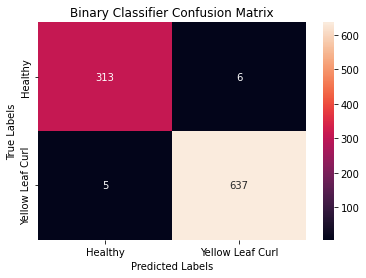

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred1), annot = True, fmt='g', ax = plt.subplot()) #annot allows me to annotate the cells, fmt='g' disables scientific notation
plt.subplot().set_title("Binary Classifier Confusion Matrix")
plt.subplot().set_xlabel("Predicted Labels")
plt.subplot().set_ylabel("True Labels")
plt.subplot().xaxis.set_ticklabels(["Healthy", "Yellow Leaf Curl"])
plt.subplot().yaxis.set_ticklabels(["Healthy", "Yellow Leaf Curl"])

In [ ]:
print(classification_report(y_test, y_pred1, target_names=["Tomato_Healthy", "Tomato_Yellow_Leaf_Curl_Virus"]))

                               precision    recall  f1-score   support

               Tomato_Healthy       0.98      0.98      0.98       319
Tomato_Yellow_Leaf_Curl_Virus       0.99      0.99      0.99       642

                     accuracy                           0.99       961
                    macro avg       0.99      0.99      0.99       961
                 weighted avg       0.99      0.99      0.99       961

